# Goals:

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

You are asked to:

Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
Explain why that might be happening. Are the localized translations really worse?
If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns

PATH = Path('data')

/home/quantran/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
test = pd.read_csv(PATH/'test_table.csv')
user = pd.read_csv(PATH/'user_table.csv')

In [9]:
test.head()
test.shape

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


(453321, 9)

In [13]:
# quick null check on test
test.isnull().sum(axis=0)

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

In [10]:
user.head()
user.shape

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


(452867, 4)

In [14]:
# quick null check on user
user.isnull().sum(axis=0)

user_id    0
sex        0
age        0
country    0
dtype: int64

In [8]:
test.user_id.value_counts().sum() == test.shape[0] # true if user_id is unique key of test
user.user_id.value_counts().sum() == user.shape[0] # true if user_id is unique key of user

True

True

In [25]:
# join user and test table
df = pd.merge(test,user,how='left',on='user_id')

In [26]:
# datetime and sort by date
df.date = pd.to_datetime(df.date)
df.sort_values('date',inplace=True)
df.reset_index(inplace=True,drop=True)

In [27]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,153920,2015-11-30,Direct,Web,ES,NaN,Chrome,0,0,M,26.0,Mexico
1,254977,2015-11-30,Ads,Mobile,ES,Facebook,Iphone_App,0,0,M,34.0,Guatemala
2,979616,2015-11-30,Direct,Web,ES,NaN,Chrome,1,0,F,28.0,Bolivia
3,757464,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1,M,27.0,Argentina
4,44717,2015-11-30,Ads,Web,ES,Yahoo,Chrome,0,0,M,45.0,Mexico


# Single feature analysis

In [30]:
df.groupby('date').size()

date
2015-11-30     71025
2015-12-01     70991
2015-12-02     70649
2015-12-03     99493
2015-12-04    141163
dtype: int64

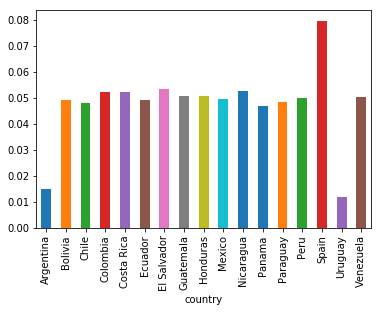

In [51]:
# check if Spain actually has high conversion rate
test_0 = df[df.test==0]
test_0.groupby('country').conversion.mean().plot(kind='bar')

In fact, conversion rate is highest for Spain

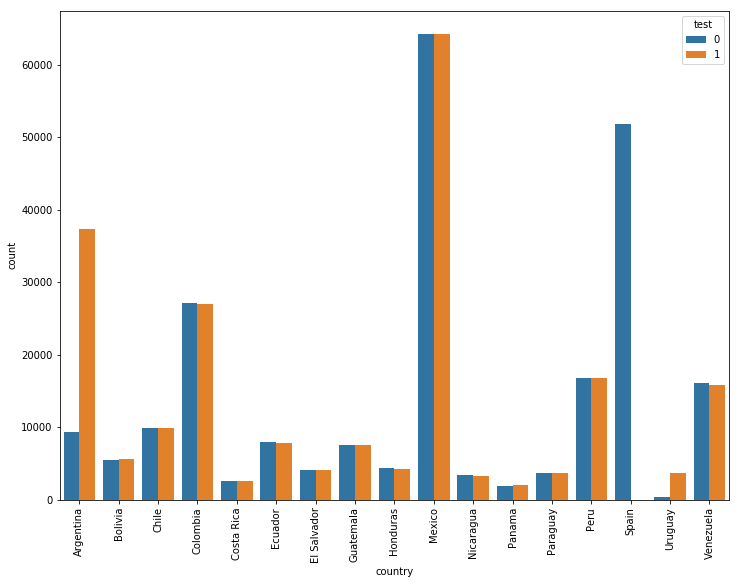

In [49]:
# check total of test and nontest record
fig,ax=plt.subplots(figsize=(12,9))
s=sns.countplot(x='country',hue='test',data=df.sort_values('country'))
plt.setp(s.get_xticklabels(),rotation=90);

Except for Argentina and Uruguay (and of course Spain since we don't test on Spain), # of test and nontest for countries are fairly equal

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


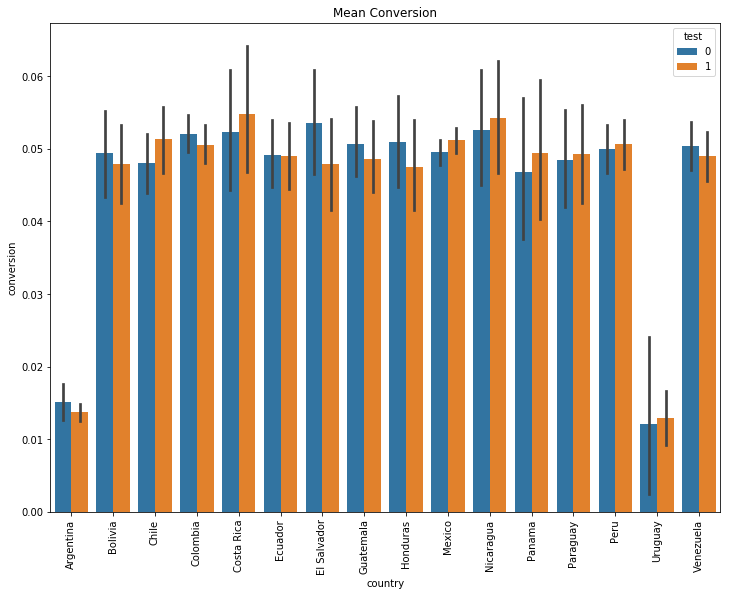

In [79]:
fig,ax=plt.subplots(figsize=(12,9))
ax=sns.barplot(x='country',y='conversion',hue='test',data = df[df.country!='Spain'].sort_values('country'),ax=ax)

plt.setp(ax.get_xticklabels(),rotation=90);
ax.set_title('Mean Conversion');


# another way to plot this
# conv_rate = df[df.country!='Spain'].groupby(['country','test']).conversion.mean().reset_index()
# ax=sns.barplot(x='country',y='conversion',hue='test',data = conv_rate,ax=ax)



We expect that conversion rate for test records (orange bar) should be higher than nontest (blue bar). We have 8 out of 16 countries who have higher conversion rate after test

TODO: EDA on Spain. EDA on 8 countries with positive test. See if they have anything in common